In [1]:
!pip3 install gymnasium[classic_control]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 11.7 MB/s eta 0:00:00


In [2]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt

In [3]:
#Hyperparameters
learning_rate = 0.0002
gamma         = 0.98
n_rollout     = 10

In [4]:
class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        self.data = []

        self.fc1 = nn.Linear(4,256)
        self.fc_pi = nn.Linear(256,2)
        self.fc_v = nn.Linear(256,1)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def pi(self, x, softmax_dim = 0):
        x = F.relu(self.fc1(x))
        x = self.fc_pi(x)
        prob = F.softmax(x, dim=softmax_dim)
        return prob

    def v(self, x):
        x = F.relu(self.fc1(x))
        v = self.fc_v(x)
        return v

    def put_data(self, transition):
        self.data.append(transition)

    def make_batch(self):
        s_lst, a_lst, r_lst, s_prime_lst, done_lst = [], [], [], [], []
        for transition in self.data:
            s,a,r,s_prime,done = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r/100.0])
            s_prime_lst.append(s_prime)
            done_mask = 0.0 if done else 1.0
            done_lst.append([done_mask])

        s_batch, a_batch, r_batch, s_prime_batch, done_batch = torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
                                                               torch.tensor(r_lst, dtype=torch.float), torch.tensor(s_prime_lst, dtype=torch.float), \
                                                               torch.tensor(done_lst, dtype=torch.float)
        self.data = []
        return s_batch, a_batch, r_batch, s_prime_batch, done_batch

    def train_net(self):
        s, a, r, s_prime, done = self.make_batch()
        td_target = r + gamma * self.v(s_prime) * done
        delta = td_target - self.v(s)

        pi = self.pi(s, softmax_dim=1)
        pi_a = pi.gather(1,a)
        loss = -torch.log(pi_a) * delta.detach() + F.smooth_l1_loss(self.v(s), td_target.detach())

        self.optimizer.zero_grad()
        loss.mean().backward()
        self.optimizer.step()

In [5]:
def main():
    env = gym.make('CartPole-v1')
    model = ActorCritic()
    print_interval = 20
    avg_scores = []
    score = 0.0
    best_score = -float('inf')

    for n_epi in range(10000):
        done = False
        truncated = False
        s, _ = env.reset()
        while not (done or truncated):
            for t in range(n_rollout):
                prob = model.pi(torch.from_numpy(s).float())
                m = Categorical(prob)
                a = m.sample().item()
                s_prime, r, done, truncated, info = env.step(a)
                model.put_data((s,a,r,s_prime,done))

                s = s_prime
                score += r

                if (done or truncated):
                    break

            model.train_net()

        if score >= best_score:
            best_score = score
            torch.save(model.state_dict(), f"actor_cartpole{n_epi}_.pth")
            print(f"New best score: {best_score}. Model saved.")


        if n_epi%print_interval==0 and n_epi!=0:
            avg_score = score / print_interval
            avg_scores.append(avg_score)  # 평균 점수 저장
            print("# of episode :{}, avg score : {:.1f}".format(n_epi, score/print_interval))
            score = 0.0

    env.close()
    plt.plot(avg_scores)
    plt.xlabel('Episodes (x20)')
    plt.ylabel('Average Score')
    plt.title('Average Score vs Episodes')
    plt.show()

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


<ipython-input-4-90b70aa6f0b9>:36: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  s_batch, a_batch, r_batch, s_prime_batch, done_batch = torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \


New best score: 22.0. Model saved.
New best score: 30.0. Model saved.
New best score: 54.0. Model saved.
New best score: 79.0. Model saved.
New best score: 93.0. Model saved.
New best score: 109.0. Model saved.
New best score: 137.0. Model saved.
New best score: 152.0. Model saved.
New best score: 165.0. Model saved.
New best score: 175.0. Model saved.
New best score: 189.0. Model saved.
New best score: 200.0. Model saved.
New best score: 210.0. Model saved.
New best score: 224.0. Model saved.
New best score: 243.0. Model saved.
New best score: 261.0. Model saved.
New best score: 290.0. Model saved.
New best score: 301.0. Model saved.
New best score: 339.0. Model saved.
New best score: 349.0. Model saved.
New best score: 368.0. Model saved.
# of episode :20, avg score : 18.4
# of episode :40, avg score : 17.8
# of episode :60, avg score : 16.9
# of episode :80, avg score : 16.2
# of episode :100, avg score : 16.1
# of episode :120, avg score : 15.2
New best score: 386.0. Model saved.
N

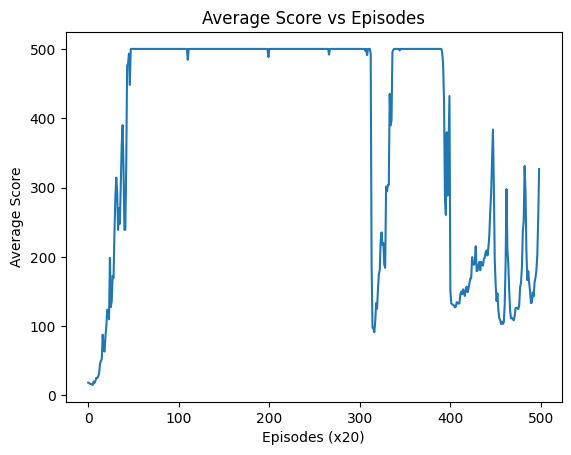

In [7]:
main()